# Spanish Football League Data Analysis - La Liga 1928 - 2021 

### Authors:

Jaume Reixach Pérez 

Ferran Iglesias Cels 

Pau Rodrigo Parés

### Introduction:

On this notebook there is a small analysis of the Spanish Football League (La Liga) from 1928 to 2021. The data source is Transfermarkt, and it was scraped using Python’s library BeautifulSoup4. The data is provided as a SQLite3 database that is inside the repository. This  data set contains a the following table:

Matches: All the matches played between seasons 1928-1929 and 2021-2022 with the date and score. Columns are season, division, matchday, date, time, home_team, away_team, score. Have in mind there is no time information for many of themand also that it contains matches still not played from current season.

Let's start the analysis:

First of all, we import the libraries we are going to use:



In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors
import seaborn as sns
import calendar
from datetime import datetime
import openpyxl
import sqlite3 #For reading data from database file

We import the data using sqlite3:

In [25]:
con = sqlite3.connect("laliga.sqlite")
df = pd.read_sql_query("SELECT * FROM Matches", con)
con.close()

Let's see the aspects of the data:

In [26]:
df.head()

,season,division,matchday,date,time,home_team,away_team,score
0,1928-1929,1,1,2/10/29,None,Arenas Club,Athletic Madrid,2:3
1,1928-1929,1,1,2/10/29,None,Espanyol,Real Unión,3:2
2,1928-1929,1,1,2/10/29,None,Real Madrid,Catalunya,5:0
3,1928-1929,1,1,2/10/29,None,Donostia,Athletic,1:1
4,1928-1929,1,1,2/12/29,None,Racing,Barcelona,0:2


**1. Is it true that the home team is more likely to win? Make a pie chart showing the result distribution (whether home team wins, visitor team wins, or there’s a tie) of all matches in the data. Write in the plot the percentage of each category.**

Local team win = 25461
Visitant team win = 10438
Draws = 12341
No data = 780


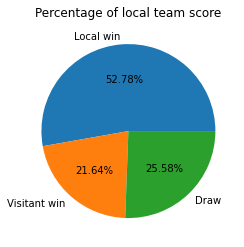

Yes, the percentage shows that the local team is more likely to win


In [4]:
local_team_win = 0
visitant_team_win = 0
draw = 0
no_score_data = 0


for i in range(len(df)):
    
    if df.score[i] is None:
        no_score_data += 1
        continue
    
    elif int(df.score[i].split(":")[0]) > int(df.score[i].split(":")[1]):
        local_team_win += 1
        continue
        
    elif int(df.score[i].split(":")[0]) < int(df.score[i].split(":")[1]):
        visitant_team_win += 1
        continue
        
    elif int(df.score[i].split(":")[0]) == int(df.score[i].split(":")[1]):
        draw += 1
        continue
con.close()

print("Local team win =", local_team_win)
print("Visitant team win =", visitant_team_win)
print("Draws =",draw)
print("No data =", no_score_data)

labels = ['Local win', 'Visitant win', 'Draw']

plt.pie([local_team_win,visitant_team_win,draw], labels=labels, autopct = '%0.2f%%')
plt.title('Percentage of local team score')
plt.show()

print('Yes, the percentage shows that the local team is more likely to win')

**2. What are the top ten scoring teams of all time? What are the ten teams that concede the most? Make two bar plot charts showing each of them. Consider only matches played in 1st division. What have been the biggest wins? Of course, when we say biggest we mean those with the highest goal difference. Show the top ten of them in a table.**

TOP 10 SCORING TEAMS
              Teams  GoalsFor  GoalsAgainst
5         Barcelona    6317.0        3281.0
2       Real Madrid    6295.0        3311.0
6          Athletic    4842.0        3906.0
11         Valencia    4656.0        3668.0
30  Atlético Madrid    4235.0        2914.0
14       Sevilla FC    3937.0        3588.0
1          Espanyol    3738.0        4059.0
24    Real Sociedad    3223.0        3153.0
17    Real Zaragoza    2705.0        2901.0
18    Celta de Vigo    2520.0        2888.0
TOP 10 TEAMS THAT CONCEDE THE MOST
              Teams  GoalsFor  GoalsAgainst
1          Espanyol    3738.0        4059.0
6          Athletic    4842.0        3906.0
11         Valencia    4656.0        3668.0
14       Sevilla FC    3937.0        3588.0
2       Real Madrid    6295.0        3311.0
5         Barcelona    6317.0        3281.0
24    Real Sociedad    3223.0        3153.0
30  Atlético Madrid    4235.0        2914.0
17    Real Zaragoza    2705.0        2901.0
18    Celta de Vigo 

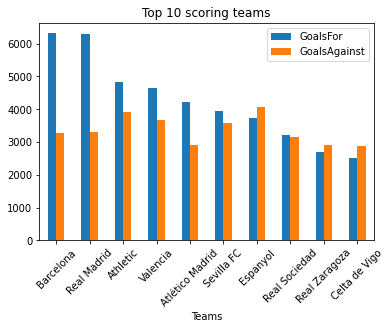

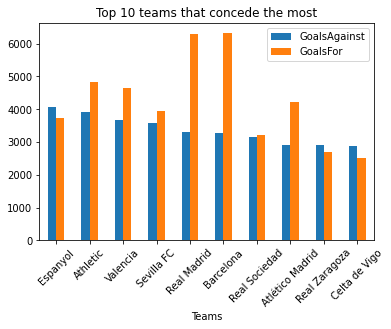

TOP 10 GOAL DIFFERENCE GAMES 
         season  division  matchday      date  time       home_team  \
225   1930-1931         1        10    2/8/31  None        Athletic   
936   1940-1941         1         1   9/29/40  None      Sevilla FC   
1168  1941-1942         1        15   1/11/42  None        Athletic   
2787  1950-1951         1        11  11/19/50  None        Athletic   
1071  1941-1942         1         1   9/28/41  None      Sevilla FC   
2574  1949-1950         1         8  10/23/49  None   Celta de Vigo   
2771  1950-1951         1         9   11/5/50  None  Dep. La Coruña   
4745  1958-1959         1        15  12/28/58  None        Athletic   
2969  1951-1952         1         3   9/23/51  None        Athletic   
2537  1949-1950         1         2   9/11/49  None       Barcelona   

          away_team score  GoalDifference  
225       Barcelona  12:1            11.0  
936       Barcelona  11:1            10.0  
1168  Celta de Vigo  10:0            10.0  
2787        

In [8]:
## Store team names
team_names = []

for i in range(len(df)):
    flag1 = 0
    
    if df.division[i] == 1:
    
        for j in range(len(team_names)):
            if df.home_team[i] == team_names[j]:
                flag1 = 1
        
        if flag1 == 0:
            team_names.append(df.home_team[i])
    
        
ex2df = pd.DataFrame(team_names, columns=['Teams'])


ex2df['GoalsFor'] = np.zeros(len(ex2df))
ex2df['GoalsAgainst'] = np.zeros(len(ex2df))

pd.options.mode.chained_assignment = None

for i in range(len(df)):
    
    if df.division[i] == 1:
    
        for j in range(len(ex2df)):
        
            if df.score[i] is None:
                break
        
            elif df.home_team[i] == ex2df.Teams[j]:
                ex2df.GoalsFor[j] += int(df.score[i].split(":")[0])
                ex2df.GoalsAgainst[j] += int(df.score[i].split(":")[1])
        
            elif df.away_team[i] == ex2df.Teams[j]:
                ex2df.GoalsFor[j] += int(df.score[i].split(":")[1])
                ex2df.GoalsAgainst[j] += int(df.score[i].split(":")[0])
            
print("TOP 10 SCORING TEAMS")
t10goalsfor = ex2df.sort_values('GoalsFor', ascending=False).head(10)
print(t10goalsfor)

print("TOP 10 TEAMS THAT CONCEDE THE MOST")
t10goalsagainst = ex2df.sort_values('GoalsAgainst', ascending=False).head(10)
print(t10goalsagainst)


t10goalsfor.plot.bar(x = 'Teams', y = ['GoalsFor','GoalsAgainst'], rot=45)
plt.title("Top 10 scoring teams")
plt.show()

t10goalsagainst.plot.bar(x = 'Teams', y = ['GoalsAgainst','GoalsFor'], rot=45)
plt.title("Top 10 teams that concede the most")
plt.show()


df['GoalDifference'] = np.zeros(len(df))
for i in range(len(df)):
    if df.score[i] is not None and df.division[i]==1:
        df.GoalDifference[i] = abs(int(df.score[i].split(":")[0])-int(df.score[i].split(":")[1]))
t10goaldiff = df.sort_values('GoalDifference', ascending=False).head(10)

print("TOP 10 GOAL DIFFERENCE GAMES ")
print(t10goaldiff)

**3. There has been a lot of discussion about how LaLiga’s television rights have changed game schedules in the last years. Make a bar plot chart showing the number of matches played each weekday, and make also a histogram of match time. Compare this two graphics between seasons 2000-2001 and 2020-2021.**

First we compare the number of matches played each weekday between seasons 2000-2001 and 2020-2021:

In [5]:
#Firts, we define a function to get the weekday of the matcc for a row in the df

def findDay(df, k):
    day = int(df.date[k].split("/")[0])
    month = int(df.date[0].split("/")[1])
    if int(str(df.season[k].split("-")[1])[-2:]) == int(str(df.date[k].split("/")[2])):
        year = int(df.season[k].split("-")[1])
    else:
        year = int(df.season[k].split("-")[0])
    dayNumber = calendar.weekday(year, month, day)
    days =["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
    return (days[dayNumber])


In [6]:
#Then, we create a list for each season and we fill it with the number of matches played in each day of the week

Season_2000_2001 = np.zeros(7)
Season_2020_2021 = np.zeros(7)
week_days =["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

for i in range(len(df)):
    
    if df.season[i] == '2000-2001':
        day = findDay(df,i)
    
        if day == 'Monday':
            Season_2000_2001[0] += 1
        elif day == 'Tuesday':
            Season_2000_2001[1] += 1
        elif day == 'Wednesday':
            Season_2000_2001[2] += 1
        elif day == 'Thursday':
            Season_2000_2001[3] += 1
        elif day == 'Friday':
            Season_2000_2001[4] += 1
        elif day == 'Saturday':
            Season_2000_2001[5] += 1
        elif day == 'Sunday':
            Season_2000_2001[6] += 1

    if df.season[i] == '2020-2021':
        day = findDay(df,i)
    
        if day == 'Monday':
            Season_2020_2021[0] += 1
        elif day == 'Tuesday':
            Season_2020_2021[1] += 1
        elif day == 'Wednesday':
            Season_2020_2021[2] += 1
        elif day == 'Thursday':
            Season_2020_2021[3] += 1
        elif day == 'Friday':
            Season_2020_2021[4] += 1
        elif day == 'Saturday':
            Season_2020_2021[5] += 1
        elif day == 'Sunday':
            Season_2020_2021[6] += 1

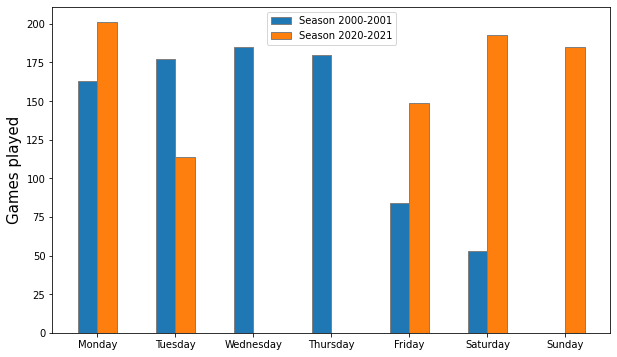

In [7]:
#Finally, we plot the results
barWidth = 0.25
fig = plt.subplots(figsize =(10, 6))
 
br1 = np.arange(len(week_days))
br2 = [x + barWidth for x in br1]


plt.bar(br1, Season_2000_2001,  width = barWidth,
        edgecolor ='grey', label ='Season 2000-2001')
plt.bar(br2, Season_2020_2021, width = barWidth,
        edgecolor ='grey', label ='Season 2020-2021')

plt.ylabel('Games played', fontsize = 15)
plt.xticks([r + barWidth/2 for r in range(len(week_days))], week_days)
 
plt.legend()
plt.show()


A notable difference is seen between the matches played each weekday for the two seasons. On one hand the 00-01 season focus their games on the first four days of the week with similar number of matches, Then comes Friday and Saturday with almost half of the matches than the other games and Sunday with zero games played, on the other hand 20-21 season focus its games on Friday, Saturday, Sunday and Monday followed by a drop of the matches on Tuesday and zero games played on the middle weekdays Wednesday and Thursday.

Now we compare the hours that the matches started been played between seasons 2000-2001 and 2020-2021:

In [8]:
# First we define the fuction to pass the time format from 12h to 24h
def timestampto24h(hour):
    if len(hour)>5:
        in_time = datetime.strptime(hour, "%I:%M %p")
        out_time = datetime.strftime(in_time, "%H:%M")
        return (out_time)
    else:
        return (hour)

In [17]:
#Now we count the matches played in each hour of the day for each season

match_time_00_01 = []  
match_time_20_21 = []

for i in range(len(df)):
    if df.time[i] != None and df.season[i] == '2000-2001':
        match_time_00_01.append(timestampto24h(df.time[i]))
        
    if df.time[i] != None and df.season[i] == '2020-2021':
        match_time_20_21.append(timestampto24h(df.time[i]))


day_hours_00_01 = np.zeros(24)
day_hours_20_21 = np.zeros(24)

for i in range(len(match_time_00_01)):
    day_hours_00_01[int(match_time_00_01[i].split(":")[0])] += 1

for i in range(len(match_time_20_21)):
    day_hours_20_21[int(match_time_20_21[i].split(":")[0])] += 1
    
    

hours = ['00:00','01:00','02:00','03:00','04:00','05:00','06:00','07:00','08:00','09:00','10:00','11:00',
         '12:00','13:00','14:00','15:00','16:00','17:00','18:00','19:00','20:00','21:00','22:00','23:00']

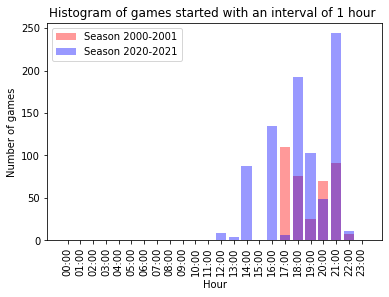

In [19]:
#Finally, we plot the results

plt.bar(x=hours, height = day_hours_00_01, color = 'red', alpha = 0.4, label='Season 2000-2001')
plt.xticks(rotation = 90)
plt.bar(x=hours, height = day_hours_20_21, color = 'blue', alpha = 0.4, label='Season 2020-2021')
plt.xticks(rotation = 90)

plt.ylabel("Number of games")
plt.xlabel("Hour")
plt.legend(loc='best')
plt.title('Histogram of games started with an interval of 1 hour ')
plt.show()


On 00-01 season the two hours that most games started are 17:00 and 21:00 with similar value, then the most relevant peaks of games are at 18:00 and 20:00. On season 20-21 most of the games started at 21:00 and 18:00 followed by 16:00 and 18:00 and we see that the peaks are mostly spaced by a 2 hour time period, not seen in 00-01 season. We do not think that we can take a firm conclusion out of this histogram since we lack lots of data of the starting time of the 00-01 season compared to the 20-21 season.")

**4. Build a cross results table for season 2020-2021 (1st division). Figure 1 is an example taken from Wikipedia. Try to make it the most similar to this one: use team abbreviations as column names and paint the background of each cell according to result (green in case local team wins and red in case visitor team wins). Also, could you model the intensity of this background color with the goal difference from the match?**


In [6]:
#Select only the matches from LaLiga Santander season 2020-2021
df_1a_20_21 = df.loc[(df["division"] == 1) & (df["season"] == "2020-2021")]

#Substitute on score column, the : for -
df_1a_20_21['score'] = df_1a_20_21['score'].str.replace(':', '-')

#Insert a new column with the result of the home team (win, lose, tie)
df_1a_20_21['result_home'] = df_1a_20_21['score'].str.split('-').str[0].astype(int) - df_1a_20_21['score'].str.split('-').str[1].astype(int)

df_1a_20_21['result_home'] = df_1a_20_21['result_home'].apply(lambda x: 'win' if x > 0 else ('lose' if x < 0 else  'tie'))
df_1a_20_21.head(10)

<ipython-input-6-a1d71cc2f9e0>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_1a_20_21['score'] = df_1a_20_21['score'].str.replace(':', '-')
<ipython-input-6-a1d71cc2f9e0>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_1a_20_21['result_home'] = df_1a_20_21['score'].str.split('-').str[0].astype(int) - df_1a_20_21['score'].str.split('-').str[1].astype(int)
<ipython-input-6-a1d71cc2f9e0>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

,season,division,matchday,date,time,home_team,away_team,score,result_home
25678,2020-2021,1,1,9/12/20,4:00 PM,SD Eibar,Celta de Vigo,0-0,tie
25679,2020-2021,1,1,9/12/20,6:30 PM,Granada CF,Athletic,2-0,win
25680,2020-2021,1,1,9/12/20,9:00 PM,Cádiz CF,CA Osasuna,0-2,lose
25681,2020-2021,1,1,9/13/20,2:00 PM,Alavés,Real Betis,0-1,lose
25682,2020-2021,1,1,9/13/20,4:00 PM,Real Valladolid,Real Sociedad,1-1,tie
25683,2020-2021,1,1,9/13/20,6:30 PM,Villarreal,SD Huesca,1-1,tie
25684,2020-2021,1,1,9/13/20,9:00 PM,Valencia,Levante,4-2,win
25685,2020-2021,1,1,1/12/21,9:30 PM,Atlético Madrid,Sevilla FC,2-0,win
25686,2020-2021,1,1,2/9/21,9:00 PM,Real Madrid,Getafe,2-0,win
25687,2020-2021,1,1,2/24/21,7:00 PM,Barcelona,Elche CF,3-0,win


In [7]:
#Build a crosstable of the score of the matches. 
table = pd.crosstab(df_1a_20_21["home_team"], df_1a_20_21["away_team"], values=df_1a_20_21["score"], aggfunc="first").fillna("-")
table

away_team,Alavés,Athletic,Atlético Madrid,Barcelona,CA Osasuna,Celta de Vigo,Cádiz CF,Elche CF,Getafe,Granada CF,Levante,Real Betis,Real Madrid,Real Sociedad,Real Valladolid,SD Eibar,SD Huesca,Sevilla FC,Valencia,Villarreal
home_team,,,,,,,,,,,,,,,,,,,,
Alavés,-,1-0,1-2,1-1,0-1,1-3,1-1,0-2,0-0,4-2,2-2,0-1,1-4,0-0,1-0,2-1,1-0,1-2,2-2,2-1
Athletic,0-0,-,2-1,2-3,2-2,0-2,0-1,1-0,5-1,2-1,2-0,4-0,0-1,0-1,2-2,1-1,2-0,2-1,1-1,1-1
Atlético Madrid,1-0,2-1,-,1-0,2-1,2-2,4-0,3-1,1-0,6-1,0-2,2-0,1-1,2-1,2-0,5-0,2-0,2-0,3-1,0-0
Barcelona,5-1,2-1,0-0,-,4-0,1-2,1-1,3-0,5-2,1-2,1-0,5-2,1-3,2-1,1-0,1-1,4-1,1-1,2-2,4-0
CA Osasuna,1-1,1-0,1-3,0-2,-,2-0,3-2,2-0,0-0,3-1,1-3,0-2,0-0,0-1,0-0,2-1,1-1,0-2,3-1,1-3
Celta de Vigo,2-0,0-0,0-2,0-3,2-1,-,4-0,3-1,1-0,3-1,2-0,2-3,1-3,1-4,1-1,1-1,2-1,3-4,2-1,0-4
Cádiz CF,3-1,0-4,2-4,2-1,0-2,0-0,-,1-3,0-2,1-1,2-2,0-1,0-3,0-1,0-0,1-0,2-1,1-3,2-1,0-0
Elche CF,0-2,2-0,0-1,0-2,2-2,1-1,1-1,-,1-3,0-1,1-0,1-1,1-1,0-3,1-1,1-0,0-0,2-1,2-1,2-2
Getafe,0-0,1-1,0-0,1-0,1-0,1-1,0-1,1-1,-,0-1,2-1,3-0,0-0,0-1,0-1,0-1,1-0,0-1,3-0,1-3


In [31]:
#Let's put the table with colours with this function

def color_score(score):
    if score == "-":
        return 'background-color: grey'
    else:
        home_score, away_score = score.split("-")
        home_score = int(home_score)
        away_score = int(away_score)
        if home_score > away_score:
            return 'background-color: green'
        elif home_score == away_score :
            return 'background-color: yellow'
        elif home_score < away_score:
            return 'background-color: red'

In [32]:
table = pd.crosstab(df_1a_20_21["home_team"], df_1a_20_21["away_team"], values=df_1a_20_21["score"], aggfunc="first").fillna("-")
table = table.style.applymap(color_score, subset = list(table.columns))
table

away_team,Alavés,Athletic,Atlético Madrid,Barcelona,CA Osasuna,Celta de Vigo,Cádiz CF,Elche CF,Getafe,Granada CF,Levante,Real Betis,Real Madrid,Real Sociedad,Real Valladolid,SD Eibar,SD Huesca,Sevilla FC,Valencia,Villarreal
home_team,,,,,,,,,,,,,,,,,,,,
Alavés,-,1-0,1-2,1-1,0-1,1-3,1-1,0-2,0-0,4-2,2-2,0-1,1-4,0-0,1-0,2-1,1-0,1-2,2-2,2-1
Athletic,0-0,-,2-1,2-3,2-2,0-2,0-1,1-0,5-1,2-1,2-0,4-0,0-1,0-1,2-2,1-1,2-0,2-1,1-1,1-1
Atlético Madrid,1-0,2-1,-,1-0,2-1,2-2,4-0,3-1,1-0,6-1,0-2,2-0,1-1,2-1,2-0,5-0,2-0,2-0,3-1,0-0
Barcelona,5-1,2-1,0-0,-,4-0,1-2,1-1,3-0,5-2,1-2,1-0,5-2,1-3,2-1,1-0,1-1,4-1,1-1,2-2,4-0
CA Osasuna,1-1,1-0,1-3,0-2,-,2-0,3-2,2-0,0-0,3-1,1-3,0-2,0-0,0-1,0-0,2-1,1-1,0-2,3-1,1-3
Celta de Vigo,2-0,0-0,0-2,0-3,2-1,-,4-0,3-1,1-0,3-1,2-0,2-3,1-3,1-4,1-1,1-1,2-1,3-4,2-1,0-4
Cádiz CF,3-1,0-4,2-4,2-1,0-2,0-0,-,1-3,0-2,1-1,2-2,0-1,0-3,0-1,0-0,1-0,2-1,1-3,2-1,0-0
Elche CF,0-2,2-0,0-1,0-2,2-2,1-1,1-1,-,1-3,0-1,1-0,1-1,1-1,0-3,1-1,1-0,0-0,2-1,2-1,2-2
Getafe,0-0,1-1,0-0,1-0,1-0,1-1,0-1,1-1,-,0-1,2-1,3-0,0-0,0-1,0-1,0-1,1-0,0-1,3-0,1-3


**Write a function that, given the season and division, plots the cross results table. Function prototype should be like plot_cross_results_table(season, division) and return the plot object.**

In [4]:
#Define the function plot_crosstab
def plot_cross_results_table (season,division):

    #Check if the season and division are valid
    if (season not in df["season"].unique()) or (division not in df["division"].unique()):
        print("Season or division not valid")
        return

    #Select the matches from the season and division
    df_aux = df.loc[(df["division"] == division) & (df["season"] == season)]
    
    #Substitute on score column, the : for -
    df_aux['score'] = df_aux['score'].str.replace(':', '-')

    #Construct the crosstable
    crosstab = pd.crosstab(df_aux["home_team"], df_aux["away_team"], values=df_aux["score"], aggfunc="first").fillna("-")

    #Apply the function color_score
    crosstab = crosstab.style.applymap(color_score, subset = list(crosstab.columns))

    return crosstab

In [29]:
#Check the function
plot_cross_results_table("2015-2016",1)

away_team,Athletic,Atlético Madrid,Barcelona,Celta de Vigo,Dep. La Coruña,Espanyol,Getafe,Granada CF,Levante,Málaga CF,Rayo Vallecano,Real Betis,Real Madrid,Real Sociedad,SD Eibar,Sevilla FC,Sporting Gijón,UD Las Palmas,Valencia,Villarreal
home_team,,,,,,,,,,,,,,,,,,,,
Athletic,-,0-1,0-1,2-1,4-1,2-1,3-1,1-1,2-0,0-0,1-0,3-1,1-2,0-1,5-2,3-1,3-0,2-2,3-1,0-0
Atlético Madrid,2-1,-,1-2,2-0,3-0,1-0,2-0,3-0,1-0,1-0,1-0,5-1,1-1,3-0,3-1,0-0,1-0,1-0,2-1,0-0
Barcelona,6-0,2-1,-,6-1,2-2,5-0,6-0,4-0,4-1,1-0,5-2,4-0,1-2,4-0,3-1,2-1,6-0,2-1,1-2,3-0
Celta de Vigo,0-1,0-2,4-1,-,1-1,1-0,0-0,2-1,4-3,1-0,3-0,1-1,1-3,1-0,3-2,1-1,2-1,3-3,1-5,0-0
Dep. La Coruña,2-2,1-1,0-8,2-0,-,3-0,0-2,0-1,2-1,3-3,2-2,2-2,0-2,0-0,2-0,1-1,2-3,1-3,1-1,1-2
Espanyol,2-1,1-3,0-0,1-1,1-0,-,1-0,1-1,1-1,2-0,2-1,0-3,0-6,0-5,4-2,1-0,1-2,1-0,1-0,2-2
Getafe,0-1,0-1,0-2,0-1,0-0,3-1,-,1-2,3-0,1-0,1-1,1-0,1-5,1-1,1-1,1-1,1-1,4-0,2-2,2-0
Granada CF,2-0,0-2,0-3,0-2,1-1,1-1,3-2,-,5-1,0-0,2-2,1-1,1-2,0-3,1-3,2-1,2-0,3-2,1-2,1-3
Levante,2-2,2-1,0-2,1-2,1-1,2-1,3-0,1-2,-,0-1,2-1,0-1,1-3,0-4,2-2,1-1,0-0,3-2,1-0,1-0


**5. As you surely know, there has always been a historical rivalry between Barcelona and Real Madrid. But which of them has won the most games in direct confrontations? Which of them has scored the most goals in these games? Show both things in two pie charts, side by side. Remember to consider ties in the first one.**

In [14]:
#Select the matches Between Barcelona and Real Madrid
df_barca_vs_rm = df.loc[(df["home_team"] == "Barcelona") & (df["away_team"] == "Real Madrid") | (df["home_team"] == "Real Madrid") & (df["away_team"] == "Barcelona")]

#Check if there ara any null values in the score column
df_barca_vs_rm["score"].isnull().sum()

#Show the rows with null values
df_barca_vs_rm[df_barca_vs_rm["score"].isnull()]

#We delete the rows with null values
df_barca_vs_rm = df_barca_vs_rm.dropna(subset=["score"])

#Check if there ara any null values in the score column
df_barca_vs_rm["score"].isnull().sum()

#Substitute on score column, the : for -
df_barca_vs_rm['score'] = df_barca_vs_rm['score'].str.replace(':', '-')

#Insert a new column with the winner of the match
df_barca_vs_rm['winner'] = df_barca_vs_rm['score'].str.split('-').str[0].astype(int) - df_barca_vs_rm['score'].str.split('-').str[1].astype(int)

df_barca_vs_rm['winner'] = np.where(df_barca_vs_rm['winner'] > 0, df_barca_vs_rm['home_team'], np.where(df_barca_vs_rm['winner'] < 0, df_barca_vs_rm['away_team'], 'tie'))

#Count the total goals of each team in the matches between Barcelona and Real Madrid

#Add to data frame columns of home and away goals
#Create a new column with the total goals of the home team

df_barca_vs_rm["home_goals"] = df_barca_vs_rm["score"].str.split('-').str[0].astype(int)

df_barca_vs_rm["away_goals"] = df_barca_vs_rm["score"].str.split('-').str[1].astype(int)


#Add a column with the name of the barcelona goals and real madrid goals
df_barca_vs_rm["barca_goals"] = np.where(df_barca_vs_rm["home_team"] == "Barcelona", df_barca_vs_rm["home_goals"], df_barca_vs_rm["away_goals"])
df_barca_vs_rm["rm_goals"] = np.where(df_barca_vs_rm["home_team"] == "Real Madrid", df_barca_vs_rm["home_goals"], df_barca_vs_rm["away_goals"]) 

#Count the total goals of each team in the matches between Barcelona and Real Madrid
barca_goals = df_barca_vs_rm["barca_goals"].sum()
madrid_goals = df_barca_vs_rm["rm_goals"].sum()

df_barca_vs_rm.head(5)


,season,division,matchday,date,time,home_team,away_team,score,winner,home_goals,away_goals,barca_goals,rm_goals
5,1928-1929,1,2,2/17/29,None,Barcelona,Real Madrid,1-2,Real Madrid,1,2,1,2
53,1928-1929,1,11,5/9/29,None,Real Madrid,Barcelona,0-1,Barcelona,0,1,1,0
131,1929-1930,1,9,1/26/30,None,Barcelona,Real Madrid,1-4,Real Madrid,1,4,1,4
176,1929-1930,1,18,3/30/30,None,Real Madrid,Barcelona,5-1,Real Madrid,5,1,1,5
221,1930-1931,1,9,2/1/31,None,Real Madrid,Barcelona,0-0,tie,0,0,0,0


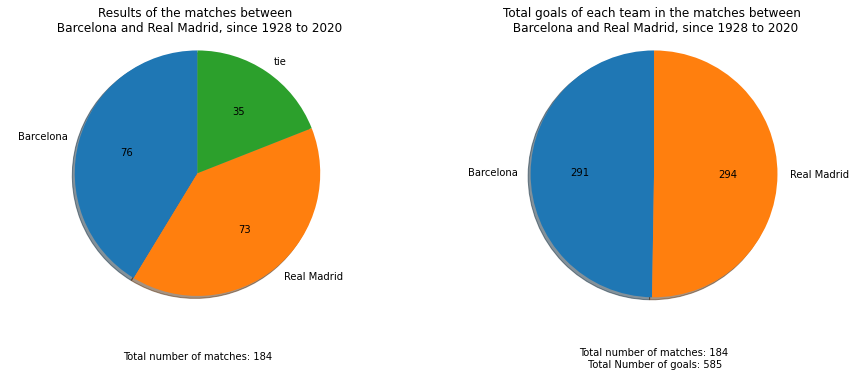

In [13]:
#Plot the 2 plots in the same figure
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
fig.set_facecolor("white")


#Plot the number of matches won by each team on a pie chart

labels = (df_barca_vs_rm["winner"].unique())
labels = sorted(labels)
sizes = df_barca_vs_rm["winner"].value_counts().values
explode = (0, 0, 0)

ax1.pie(sizes, explode = explode, labels = labels, autopct = lambda p: '{:.0f}'.format(p * sum(sizes) / 100),shadow = True, startangle=90) #With total number of matches won    
#ax1.pie(sizes, explode=explode, labels=labels, autopct = '%1.1f%%', shadow=True, startangle=90) #With Percentage

#Title and subtitle of the pie chart
ax1.set_title("Results of the matches between \n Barcelona and Real Madrid, since 1928 to 2020")
ax1.text(0, -1.5, "Total number of matches: " + str(df_barca_vs_rm.shape[0]), ha='center', va='center')
ax1.axis('equal')


#Plot the total goals of each team in the matches between them on a pie chart

labels = df_barca_vs_rm["home_team"].unique()
labels = sorted(labels)
sizes = [barca_goals, madrid_goals]
explode = (0, 0)

ax2.pie(sizes, explode = explode, labels = labels, autopct = lambda p: '{:.0f}'.format(p * sum(sizes) / 100),shadow = True, startangle=90) #With total number of goals
#ax2.pie(sizes, explode=explode, labels=labels, autopct = '%1.1f%%', shadow=True, startangle=90) #With Percentage

#Title and subtitle of the pie chart
ax2.set_title("Total goals of each team in the matches between \n Barcelona and Real Madrid, since 1928 to 2020")
ax2.text(0, -1.5, "Total number of matches: " + str(df_barca_vs_rm.shape[0]) + '\n Total Number of goals: ' + str((barca_goals + madrid_goals)), ha='center', va='center')
ax2.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.


plt.show()


**Write a function that, given two team names, plots the two graphs described above. Function prototype should be like plot_direct_confrontations_stats(team1, team2) and return the plot object. Use it with some other classical rivals like Betis and Sevilla.**

In [38]:
def plot_direct_confrontations_stats(team1, team2):

    #Select and clean data
    df_aux = df.loc[(df["home_team"] == team1) & (df["away_team"] == team2) | (df["home_team"] == team2) & (df["away_team"] == team1)]

    #Null values
    #Check if there ara any null values in the score column
    null_values = df_aux["score"].isnull().sum()

    #create small df with the null values
    df_null_values = df_aux[df_aux["score"].isnull()]
    print("Number of null values in the score column: " + str(null_values))
    print(df_null_values)

    #Drop the null values from aux df
    df_aux = df_aux.dropna(subset=["score"])

    #Substitute on score column, the : for -
    df_aux['score'] = df_aux['score'].str.replace(':', '-')

    #Select de date of first match and for the last
    #first_date = df_aux.loc[0,'date']
    #last_date = df_aux.loc[df_aux.shape[0]-1,'date']
    
    #Insert a new column with the winner of the match
    df_aux['winner'] = df_aux['score'].str.split('-').str[0].astype(int) - df_aux['score'].str.split('-').str[1].astype(int)
    df_aux['winner'] = np.where(df_aux['winner'] > 0, df_aux['home_team'], np.where(df_aux['winner'] < 0, df_aux['away_team'], 'tie'))

    #Count the total wins of each team in the matches
    team1_wins = df_aux["winner"].value_counts()[team1]
    team2_wins = df_aux["winner"].value_counts()[team2]
    ties = df_aux["winner"].value_counts()['tie']

    #Add to data frame columns of home and away goals
    df_aux["home_goals"] = df_aux["score"].str.split('-').str[0].astype(int)
    df_aux["away_goals"] = df_aux["score"].str.split('-').str[1].astype(int)

    #Add a column with the number of goals of team1 and team2 on each match
    df_aux[team1 + "_goals"] = np.where(df_aux["home_team"] == team1, df_aux["home_goals"], df_aux["away_goals"])
    df_aux[team2 + "_goals"] = np.where(df_aux["home_team"] == team2, df_aux["home_goals"], df_aux["away_goals"])

    #Count the total goals of each team in the matches 
    team1_goals = df_aux[team1 + "_goals"].sum()
    team2_goals = df_aux[team2 + "_goals"].sum()

    #Plot the 2 plots in the same figure
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    fig.set_facecolor("white")

    #Plot the number of matches won by each team on a pie chart
    labels = [team1 , team2, "tie"]
    sizes = [team1_wins, team2_wins, ties]
    explode = (0, 0, 0)

    #Plot With total number of matches won
    ax1.pie(sizes, explode = explode, labels = labels, autopct = lambda p: '{:.0f}'.format(p * sum(sizes) / 100),shadow = True, startangle=90)

    #Plot with percentatge of wins
    #ax1.pie(sizes, explode=explode, labels=labels, autopct = '%1.1f%%', shadow=True, startangle=90)

    #Title and subtitle of the pie chart
    ax1.set_title("Results of the matches between \n " + team1 + " and " + team2 + ", since 1928 to 2020")
    ax1.text(0, -1.5, "Total number of matches: " + str(df_aux.shape[0]), ha='center', va='center')
    ax1.axis('equal')


    #Plot the total goals of each team in the matches between them on a pie chart
    labels = [team1, team2]
    sizes = [team1_goals, team2_goals]
    explode = (0, 0)

    #Plot with total number of goals
    ax2.pie(sizes, explode = explode, labels = labels, autopct = lambda p: '{:.0f}'.format(p * sum(sizes) / 100),shadow = True, startangle=90)

    #Plot with percentatge of total goals
    #ax2.pie(sizes, explode=explode, labels=labels, autopct = '%1.1f%%', shadow=True, startangle=90)

    #Title and subtitle of the pie chart
    ax2.set_title("Total goals of each team in the matches between \n " + team1 + " and " + team2 + ", since 1928 to 2020")
    ax2.text(0, -1.5, "Total number of matches: " + str(df_aux.shape[0]) + '\n Total Number of goals: ' + str((team1_goals + team2_goals)), ha='center', va='center')
    ax2.axis('equal') 

    plt.show()

Number of null values in the score column: 2
          season  division  matchday     date  time   home_team   away_team  \
48300  2021-2022         1        13  11/7/21  None  Real Betis  Sevilla FC   
48435  2021-2022         1        26  2/27/22  None  Sevilla FC  Real Betis   

      score  GoalDifference  
48300  None             0.0  
48435  None             0.0  


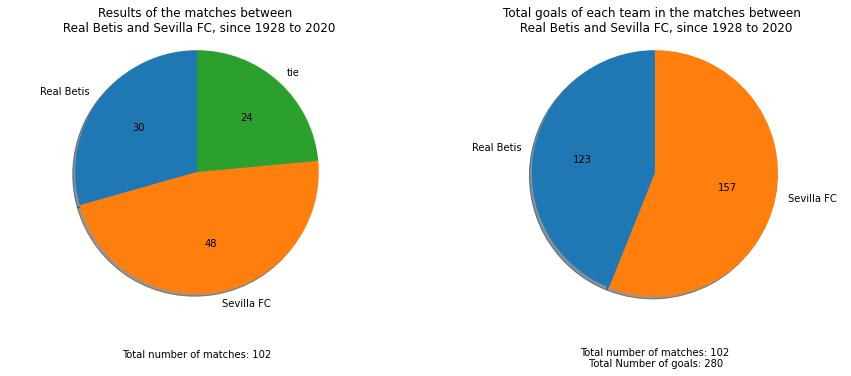

Number of null values in the score column: 2
          season  division  matchday     date  time   home_team   away_team  \
48300  2021-2022         1        13  11/7/21  None  Real Betis  Sevilla FC   
48435  2021-2022         1        26  2/27/22  None  Sevilla FC  Real Betis   

      score  GoalDifference  
48300  None             0.0  
48435  None             0.0  


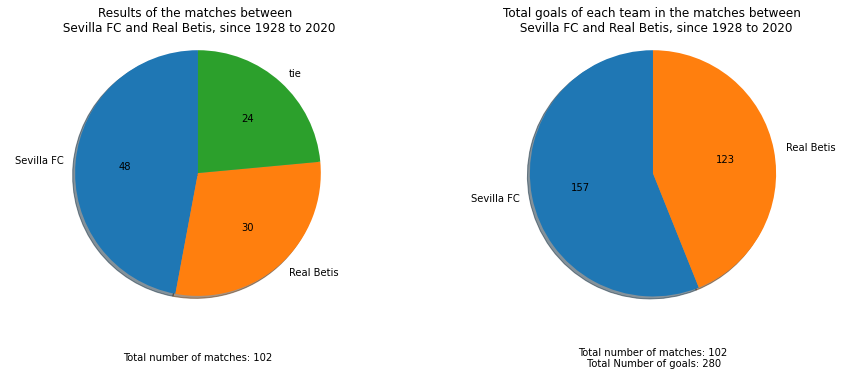

In [39]:
#Check the function with the rivalry between Betis and Sevilla FC and check that it works independent of the arguments order
plot_direct_confrontations_stats("Real Betis", "Sevilla FC")
plot_direct_confrontations_stats("Sevilla FC", "Real Betis")

**6. Between 1979 and 1980, Real Sociedad managed to chain a total of 38 games without losing. That was, by far, the longest undefeated streak in their history. Which teams have had the longest undefeated streaks? Show the longest undefeated streaks in a horizontal bar plot, indicating in each bar the team name and the dates it held that streak, for instance, Real Sociedad 22/04/1979 - 04/05/1980.**

**7. Create a table with the final standings of each season (and division), that is, a table that contains all the teams ordered (in descending order) by the number of points they got during that season, and some other aggregate statistics. The table must contain the following columns: season, division, ranking, team, GF (total goals scored), GA (total goals conceded), GD (goals difference), W (total wins), L (total loses), T (total ties), Pts (points). Remember that, in football, you earn 3 points per victory, and 1 point per tie (none for loses). In case two teams have same number of points, order by GD (descending), and then by GF (also descending). Order the table so that standings of one season come before standings of previous one, and standings of 1st division come before standings of 2nd division.**

In [41]:
df.dropna(subset = ['score'], inplace = True)
df["home_score"] = df.apply(lambda x: int(x["score"].split(":")[0]), axis = 1)
df["away_score"] = df.apply(lambda x: int(x["score"].split(":")[1]), axis = 1)
df["winner"] = df.apply(lambda x : x["home_team"] if(x["home_score"] > x["away_score"]) else (x["away_team"] if(x["home_score"] < x["away_score"]) else "NaN"), axis = 1)
df["loser"] = df.apply(lambda x : x["home_team"] if(x["home_score"] < x["away_score"]) else (x["away_team"] if(x["home_score"] > x["away_score"]) else "NaN"), axis = 1)

In [43]:
results = df.groupby(["season",'away_team', 'division']).size().reset_index(name = "count")
results.rename(columns = {"away_team" : "team"}, inplace = True)
results.drop(columns = "count", inplace = True)
wins = df.groupby(["season",'winner', 'division']).size().reset_index(name = "W")
loses = df.groupby(["season",'loser', 'division']).size().reset_index(name = "L")
wins.rename(columns = {"winner" : "team"}, inplace = True)
loses.rename(columns = {"loser" : "team"},inplace = True)
results = pd.merge(results, wins, on=['season', 'team', 'division'], how='left').fillna(0)
results = pd.merge(results, loses, on = ['season', 'team', 'division'], how = 'left').fillna(0)
games_home = df.groupby(['season','home_team', 'division']).size().reset_index(name = "games_home").fillna(0).rename(columns = {'home_team' : 'team'})
games_away = df.groupby(['season','away_team', 'division']).size().reset_index(name = "games_away").fillna(0).rename(columns = {'away_team' : 'team'})
games_played = pd.merge(games_home,games_away, on=['season','team', 'division']).fillna(0)
games_played['total'] = games_played['games_away'] + games_played['games_home']
games_played.drop(columns = ['games_home','games_away'],inplace = True)
results = pd.merge(results,games_played, on = ['season','team', 'division'], how = 'left')
results["T"] = results['total'] - results['W'] - results['L']
results.drop(columns = ['total'], inplace = True)
results['Pts'] = 3 * results['W'] + 1 * results['T']
results.sort_values(by = ['season','division','Pts'], ascending = [False, True, False], inplace = True)
results['rank'] = results.groupby(['division','season'])['Pts'].rank(ascending=False)

In [44]:
goals_home = df.groupby(['season', 'home_team', 'division']).sum(['home_score', 'away_score'])
goals_away = df.groupby(['season', 'away_team', 'division']).sum(['home_score', 'away_score'])
goals_home.reset_index(inplace = True)
goals_away.reset_index(inplace = True)
goals_home.drop(columns = ['matchday'], inplace = True)
goals_away.drop(columns = ['matchday'], inplace = True)
goals_home.rename(columns = {'home_score' : 'GF_as_home_team', 'away_score' : 'GA_as_home_team', 'home_team' : 'team'}, inplace = True)
goals_away.rename(columns = {'home_score' : 'GA_as_away_team', 'away_score' : 'GF_as_away_team', 'away_team' : 'team'}, inplace = True)
goals = pd.merge(goals_home, goals_away, on = ['season','division','team'])
goals['GF'] = goals['GF_as_home_team'] + goals['GF_as_away_team']
goals['GA'] = goals['GA_as_home_team'] + goals['GA_as_away_team']
goals.drop(columns = ['GF_as_home_team', 'GA_as_home_team', 'GA_as_away_team', 'GF_as_away_team'], inplace = True)
results = pd.merge(results, goals, on = ['season', 'division', 'team'], how = 'left')
results['GD'] = results['GF'] - results['GA']
results = results[['season', 'division', 'rank', 'team', 'GF', 'GA', 'GD', 'W', 'L', 'T', 'Pts']]
results.dropna(inplace = True)
results = results.astype({'rank' : 'int', 'GF' : 'int', 'GA' : 'int', 'GD' : 'int', 'W': 'int', 'L' : 'int', 'T': 'int', 'Pts' : 'int'})

**Save the final table in Excel with the name SeasonStandings.xlsx in the reports/ folder.**

In [48]:
results.to_excel("exercise7.xlsx")

**8. Villarreal is a team that has grown a lot in recent decades. Specially ever since some billionaire guy bought it (Fernando Roig, from Mercadona). Make a line plot showing the rank of Villarreal at the end of each season, from the oldest ones (left) to the earliest ones (right). Consider rankings in 2nd division to be a continuation of the 1st one, that is, if there’s N teams in 1st division and Villarreal got r position in 2nd division, then it should be placed in N + r. Draw in the same plot a line showing the cut between 1st and 2nd division.**

In [49]:
number_of_teams = results.groupby(['season','division']).count()
number_of_teams.drop(columns = ['rank','GF','GA','GD','Pts','L','W','T'], inplace = True)
number_of_teams.rename(columns = {'team' : 'n_of_teams'}, inplace = True)
number_of_teams.reset_index(inplace = True)
n_of_teams_per_season_first_division = {}
seasons = np.unique(results['season'])
for i in seasons:
    n_of_teams_per_season_first_division[i] = number_of_teams.loc[(number_of_teams['season'] == i) & (number_of_teams['division'] == 1)]['n_of_teams'].values[0]

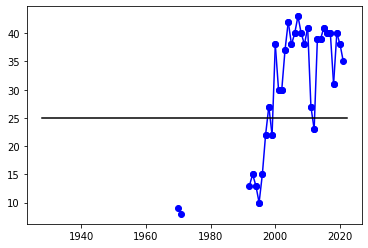

In [50]:
vilarreal_results = results.loc[results['team'] == 'Villarreal']
vilarreal_seasons = vilarreal_results['season'].values

division_per_season = {}
rank_per_season = {}
for i in vilarreal_seasons:
    division_per_season[i] = vilarreal_results.loc[vilarreal_results['season'] == i]['division'].values[0]
    rank_per_season[i] = vilarreal_results.loc[vilarreal_results['season'] == i]['rank'].values[0]

y = []
for i in vilarreal_seasons:
    if(division_per_season[i] == 1): 
        y.append(n_of_teams_per_season_first_division[i] - rank_per_season[i] + 25)
    else:
        y.append(25 - rank_per_season[i])
        
x = []
for i in vilarreal_seasons:
    x.append(int(i.split('-')[0]))

for i in range(0, len(x) - 1):
    if(x[i+1] == x[i] - 1): plt.plot([x[i], x[i + 1]], [y[i], y[i + 1]], 'bo-')
plt.plot([1928, 2022],[25, 25], 'k-')


**Write a function that, given n team names, plots the graph described above of each one of them superposed. Function prototype should be like plot_ranking_evolution(team1, team2, ..., teamN) and return the plot object (note that function should not take one array-type argument, but n arguments). Use it to compare the evolution of all the teams that currently play in 1st division.**

In [51]:
def ranking_evolution(*teams):
    colors = ['b', 'r','g','c','m','y','k']
    k = 0
    for team in teams:
        team_results = results.loc[results['team'] == team]
        team_seasons = team_results['season'].values
        division_per_season = {}
        rank_per_season = {}
        for i in team_seasons:
            division_per_season[i] = team_results.loc[team_results['season'] == i]['division'].values[0]
            rank_per_season[i] = team_results.loc[team_results['season'] == i]['rank'].values[0]
        y = []
        for i in team_seasons:
            if(division_per_season[i] == 1):
                y.append(n_of_teams_per_season_first_division[i] - rank_per_season[i] + 26)
            else:
                y.append(25 - rank_per_season[i])
        x = []
        for i in team_seasons:
            x.append(int(i.split('-')[0])) 
        label = ''
        for i in range(0, len(x) - 1):    
            if(x[i+1] == x[i] - 1): 
                if label == '': label = team
                else: label = None
                plt.plot([x[i], x[i + 1]], [y[i], y[i + 1]], 'o-', color = colors[k], label = label)
        k = k + 1
    plt.plot([1928, 2022],[25, 25], 'k-')
    plt.legend(title='Teams:')

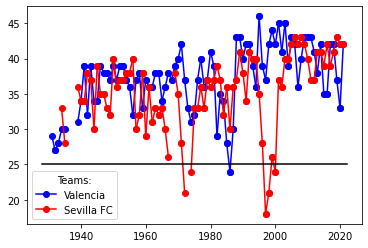

In [60]:
ranking_evolution('Valencia','Sevilla FC')

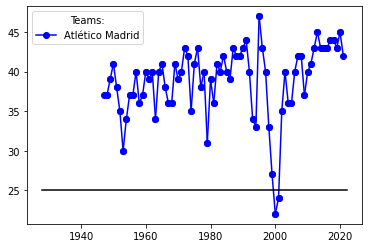

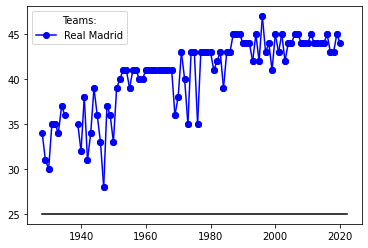

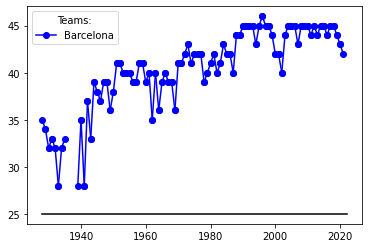

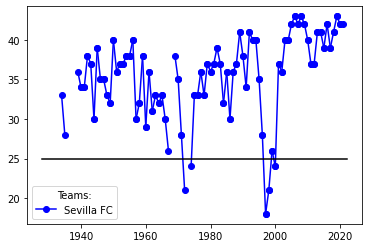

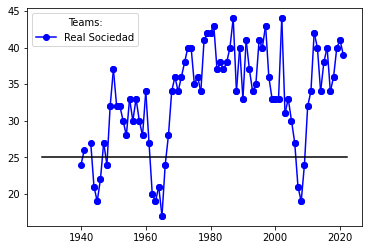

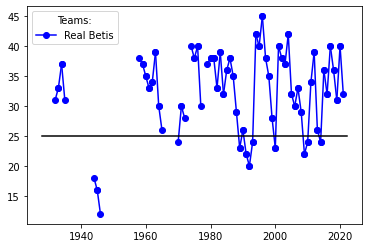

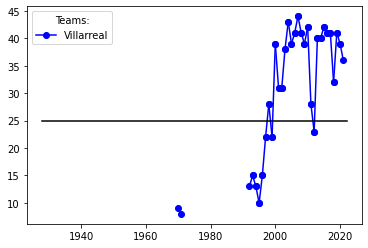

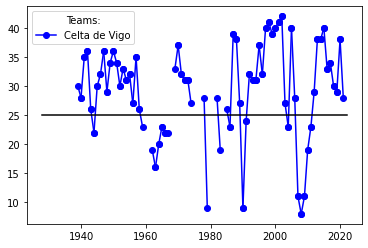

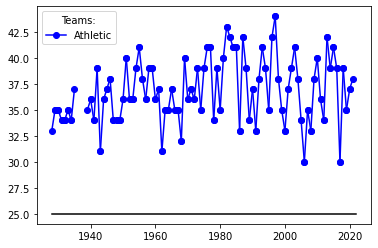

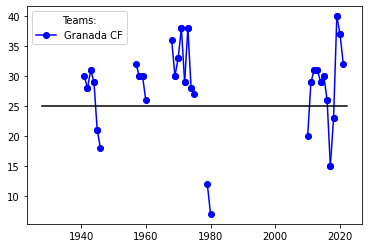

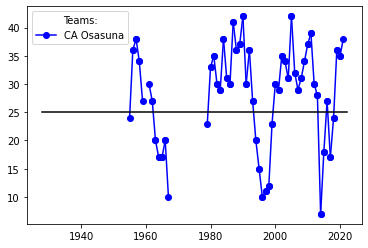

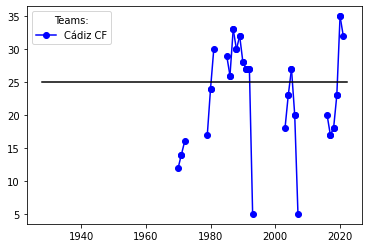

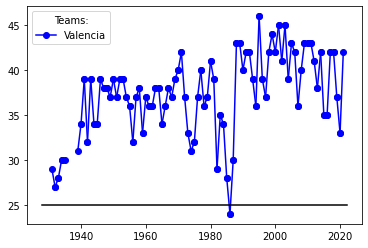

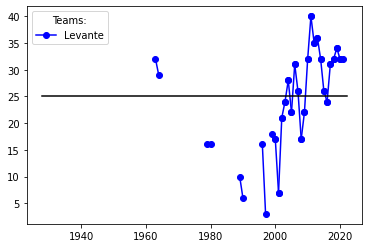

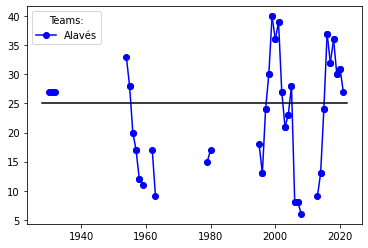

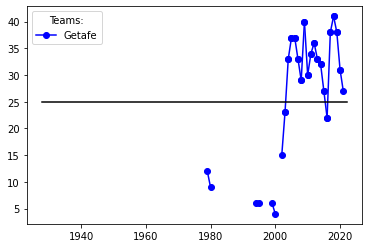

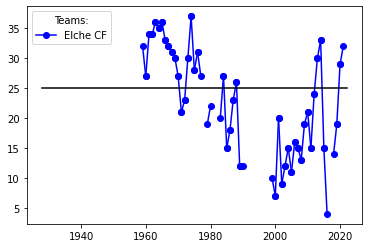

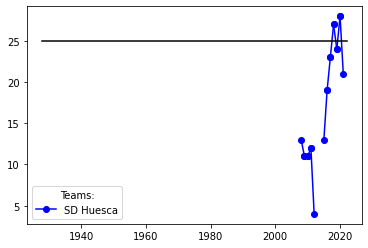

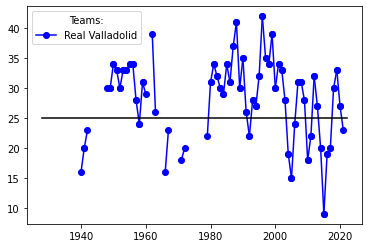

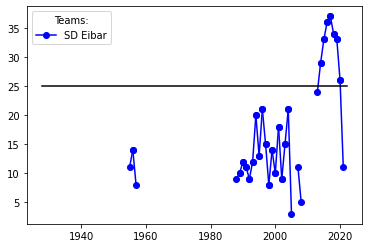

In [61]:
#Plot for all teams
first_division_teams = results.loc[(results['season'] == '2020-2021') & (results['division'] == 1)]['team'].values
len(first_division_teams)
for i in range(0, len(first_division_teams)):
    plt.figure(i+1)
    ranking_evolution(first_division_teams[i])

**9. In football jargon, those teams that are permanently descending and ascending between 1st and 2nd division are called elevator teams. What are the most elevator teams in LaLiga? Plot the history of the top 5 of them using the function from exercise 9.**

In [62]:
teams = np.unique(results['team'])
DivisionChanges = {}
for team in teams:
    TeamSeasons = np.unique(results.loc[results['team'] == team].season)
    DivisionChanges[team] = 0
    divisions = []
    for i in range(0, len(TeamSeasons)):
        divisions.append(results.loc[(results['season'] == TeamSeasons[i]) & (results['team'] == team)]['division'].values[0])
    for i in range(0, len(TeamSeasons) - 1):
        if(divisions[i] != divisions[i + 1]): DivisionChanges[team] += 1
max(DivisionChanges, key = DivisionChanges.get)

'Dep. La Coruña'

In [63]:
DivisionChangesSorted = sorted(DivisionChanges, key = DivisionChanges.get)
n = len(DivisionChangesSorted)
ElevatorTeams = DivisionChangesSorted[n-5 : n]
print('Top 5 elevator teams:')
print('---------------------')
for team in ElevatorTeams:
    print(f'{team} number of division changes = {DivisionChanges[team]}')

Top 5 elevator teams:
---------------------
Real Valladolid number of division changes = 14
Rayo Vallecano number of division changes = 15
Celta de Vigo number of division changes = 17
Racing number of division changes = 17
Dep. La Coruña number of division changes = 20


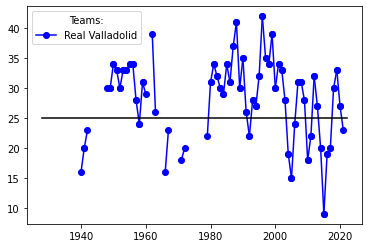

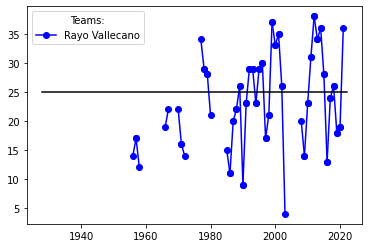

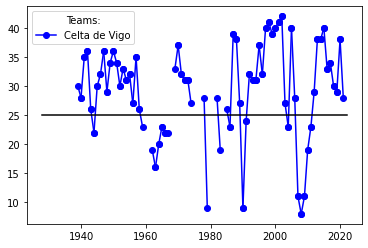

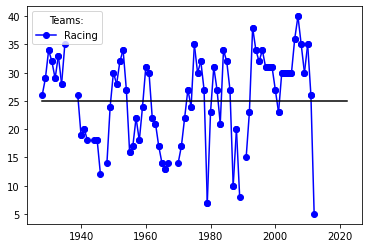

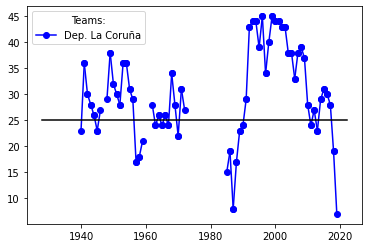

In [64]:
for i in range(0, len(ElevatorTeams)):
    plt.figure(i+1)
    ranking_evolution(ElevatorTeams[i])

**10. Create a table that is the same as the one in exercise 7, but not only with the season final standings, but the standings at the end of each matchday. Columns are the same, including matchday that tells about which matchday from the season these standings are from. Would you be able to add a new column last_5 with the result of last 5 matches? This column should contain a list like ["W", "L", "W", "T", "T"]. In this list, the first item is the immediate previous match, the second one is the match before this one, and so on. If there are no 5 previous matches (because matchday < 6, for instance) then just make the list shorter. Save the final table in Excel with the name MatchdayStandings.xlsx in the reports/ folder.**